In [93]:
# Cell loads the data

from dataset_loader import data_loader, get_descriptors, one_filter, data_scaler
import os, sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
from sklearn import preprocessing
# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)
data = data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )
X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)
# removes catagorical varaiables
test=data.drop(["MOF ID","topology","First nodular character","Second nodular character"],axis=1)
#g_comp=5
# all vs just used !!!! uncomment below for just feature used anaylsis
g_comp=6
test=test[['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']]
g=preprocessing.StandardScaler().fit_transform(test)
g=pd.DataFrame(g)
g.columns=test.columns
test=g

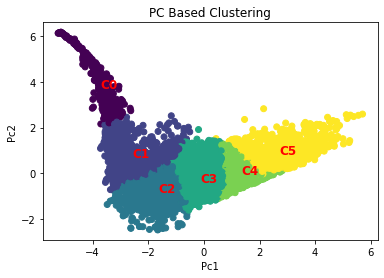

In [94]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Functions.Statistics_helper import make_pca_agg_fit
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
var=.9
g_comp=6
#make PCA to run 
data2=data.copy()
pc1,pc2,color=make_pca_agg_fit(1,test,var,g_comp,func_give=KMeans,array_out=True)
dic={
    "Pc1" : pc1,
    "Pc2" : pc2,
    "Cluster" : color,
}
holder=pd.DataFrame(dic)
data2=pd.concat([data2,holder],axis=1)

data2["Cluster"]=data2["Cluster"].apply(manual_swap)
plt.scatter(data2["Pc1"],data2["Pc2"],c=data2["Cluster"])
plt.ylabel("Pc2")
plt.xlabel("Pc1")
plt.title("PC Based Clustering")
abridge=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','H2@100 bar/243K (wt%)','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']]
new=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','H2@100 bar/243K (wt%)','Pore diameter Limiting', 'Pore diameter Largest','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']].groupby("Cluster").mean()
#plt.scatter(new["Pc1"],new["Pc2"],c="r")
annotations=["C0","C1","C2","C3","C4","C5"]
for i, label in enumerate(annotations):
    plt.annotate(label, (new["Pc1"][i],new["Pc2"][i]),weight='bold',c="r",size=12)

In [95]:
def manual_swap(x):
    #swaps clusters to order from left to right on pca
    x=int(x)
    y=0
    if x == 5:
         y=0
    elif x == 2:
        y= 1
    elif x== 1:
        y=2
    elif x == 4:
        y=3
    elif x == 0:
        y=4
    else:
        y=5
    return y

In [96]:
dic={}
for i in abridge["topology"].unique():
    dic[i]=[]
for i in range(6):
    Cluster1=abridge[abridge["Cluster"]==i]
    for j in abridge["topology"].unique():
        if sum(Cluster1["topology"]==j) > 0:
            dic[j].append(sum(Cluster1["topology"]==j))
        else:
            dic[j].append(0)

In [97]:
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]

In [98]:
Cluster1

,MOF ID,void fraction,Vol. S.A.,Grav. S.A.,Pore diameter Limiting,Pore diameter Largest,H2@100 bar/243K (wt%),topology,First nodular symmetry code,First nodular character,First nodular ID,Second nodular symmetry code,Second nodular character,Second nodular ID,Connecting building block ID,Pc1,Pc2,Cluster
0,1,0.69,1763,2215.0,6.2,7.9,1.4,acs,7,metaliic,4,7,metallic,4,10.0,-3.103060,0.261744,1
1,2,0.64,1490,1791.0,8.1,8.8,1.2,acs,7,metaliic,4,7,metallic,4,11.0,-3.039169,1.011479,1
10,11,0.67,1965,1982.0,7.6,8.0,0.9,acs,7,metaliic,4,7,metallic,4,1.0,-3.308877,0.148155,1
21,22,0.68,1808,1934.0,7.2,7.9,1.0,acs,7,metaliic,4,7,metallic,4,2.0,-3.186011,0.321855,1
23,24,0.76,1744,3119.0,11.3,12.7,1.8,acs,7,metaliic,4,7,metallic,4,31.0,-2.225720,-0.046358,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13501,13511,0.73,1499,2119.0,10.7,12.9,1.5,tpt,5,organic,9,7,metallic,4,5.0,-2.375941,0.626466,1
13502,13512,0.79,1468,2468.0,13.7,15.5,1.7,tpt,5,organic,9,7,metallic,4,6.0,-1.824971,0.419623,1
13503,13513,0.77,1279,2268.0,16.1,17.9,1.9,tpt,5,organic,9,7,metallic,4,7.0,-1.589320,0.898877,1
13504,13514,0.71,1402,2147.0,10.0,13.2,1.6,tpt,5,organic,9,7,metallic,4,8.0,-2.387767,0.838841,1


50
100
150
200
250
300
350
400
450
500


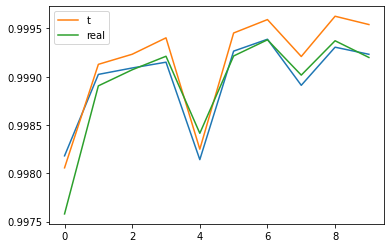

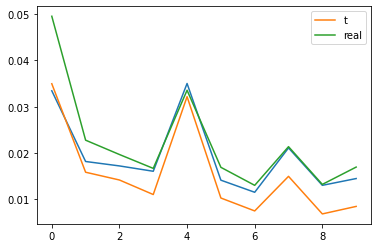

50
100
150
200
250
300
350
400
450
500


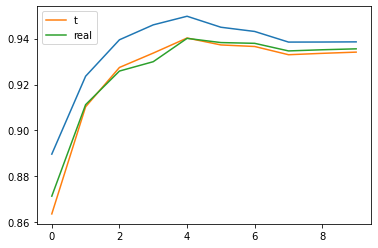

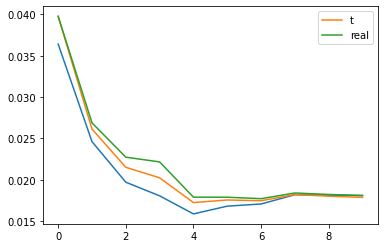

In [99]:
# help function
from transfer_learning import NeuralNet_sherpa_optimize
from dataset_loader import data_loader, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# New
from transfer_learning import MyDataset
from Statistics_helper import stratified_cluster_sample
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.metrics.regression import R2Score
import time
from ignite.engine import Events, create_supervised_evaluator
import sherpa
from sklearn.metrics import r2_score


# file name and data path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()
file_name = "data/CrystGrowthDesign_SI.csv"

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
one_filter_columns = ["H2@100 bar/243K (wt%)"]
#another_filter_columns = ['CH4@100 bar/298 K (mg/g)']

# load data
data = Cluster5
data = data.reset_index(drop=True)
epochs = 500
batch_size = 128
# parameters
input_size = 5
output_size = 1
# file specifics 
#filename = f"data_epochs-{epochs}_bs-{batch_size}"
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#format data
learning_rate = trial_parameters["lr"]
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)
df = df[0]
df=df.drop("Cluster",axis=1)
#descriptor_columns.append("Cluster")
interest = one_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_test, y_df_train, y_df_test = train_test_split(
    df[features], df[interest], test_size=0.2
)
y_df_train=y_df_train.reset_index(drop=False)
df_train, df_val, y_df_train, y_df_val = train_test_split(
    df_train[features], y_df_train[interest], test_size=0.2
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
df_test[interest]=np.array(y_df_test)


interest=one_filter_columns[0]

first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []
#create model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)


metrics = {"loss": Loss(criterion), "r_2": R2Score()}

#train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
# train_evaluator.logger = setup_logger("Train Evaluator")
#validation_evaluator = create_supervised_evaluator(
#    model, metrics=metrics, device=device
#)
# validation_evaluator.logger = setup_logger("Val Evaluator")
@trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    print(e)



train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size,shuffle=True)
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
loud=True
if loud:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []


descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]


model.fc1.weight.requires_grad = False
model.fc1.bias.requires_grad = False
model.fc2.weight.requires_grad = False
model.fc2.bias.requires_grad = False


optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
)

data = Cluster2
data = data.reset_index(drop=True)
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)

df = df[0]
df=df.drop("Cluster",axis=1)

interest = one_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_test, y_df_train, y_df_test = train_test_split(
    df[features], df[interest], test_size=0.2
)
y_df_train=y_df_train.reset_index(drop=False)
df_train, df_val, y_df_train, y_df_val = train_test_split(
    df_train[features], y_df_train[interest], test_size=0.2
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
df_test[interest]=np.array(y_df_test)


interest=one_filter_columns[0]

first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

def train_step_1(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()


transfer_trainer = Engine(train_step_1)
metrics = {"loss": Loss(criterion), "r_2": R2Score()}
@transfer_trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    print(e)
transfer_trainer.logger.disabled=True
transfer_trainer.run(train_loader, max_epochs=epochs)
if loud:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()


50
100
150
200
250
300
350
400
450
500


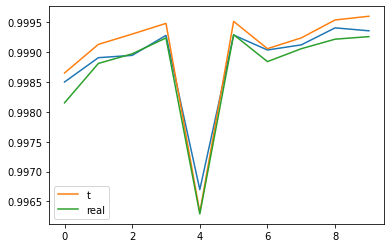

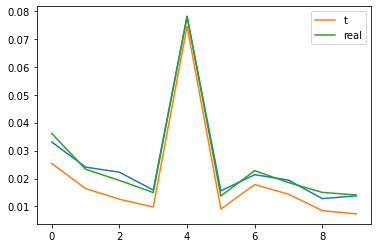

50
100
150
200
250
300
350
400
450
500


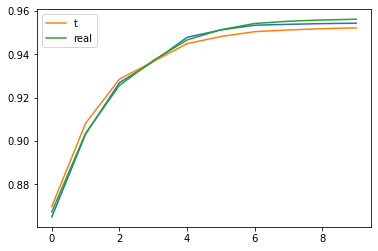

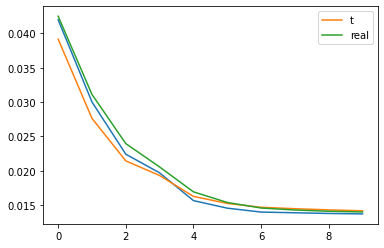

In [79]:
# help function
from transfer_learning import NeuralNet_sherpa_optimize
from dataset_loader import data_loader, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# New
from transfer_learning import MyDataset
from Statistics_helper import stratified_cluster_sample
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.metrics.regression import R2Score
import time
from ignite.engine import Events, create_supervised_evaluator
import sherpa
from sklearn.metrics import r2_score


# file name and data path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()
file_name = "data/CrystGrowthDesign_SI.csv"

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
one_filter_columns = ["H2@100 bar/243K (wt%)"]
#another_filter_columns = ['CH4@100 bar/298 K (mg/g)']

# load data
data = Cluster5
data = data.reset_index(drop=True)
epochs = 500
batch_size = 128
# parameters
input_size = 5
output_size = 1
# file specifics 
#filename = f"data_epochs-{epochs}_bs-{batch_size}"
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#format data
learning_rate = trial_parameters["lr"]
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)
df = df[0]
df=df.drop("Cluster",axis=1)
#descriptor_columns.append("Cluster")
interest = one_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_test, y_df_train, y_df_test = train_test_split(
    df[features], df[interest], test_size=0.2
)
y_df_train=y_df_train.reset_index(drop=False)
df_train, df_val, y_df_train, y_df_val = train_test_split(
    df_train[features], y_df_train[interest], test_size=0.2
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
df_test[interest]=np.array(y_df_test)


interest=one_filter_columns[0]

first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []
#create model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)


metrics = {"loss": Loss(criterion), "r_2": R2Score()}

#train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
# train_evaluator.logger = setup_logger("Train Evaluator")
#validation_evaluator = create_supervised_evaluator(
#    model, metrics=metrics, device=device
#)
# validation_evaluator.logger = setup_logger("Val Evaluator")
@trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    print(e)



train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size,shuffle=True)
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
loud=True
if loud:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []


descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]


model.fc1.weight.requires_grad = False
model.fc1.bias.requires_grad = False
model.fc2.weight.requires_grad = False
model.fc2.bias.requires_grad = False


optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
)

data = Cluster2
data = data.reset_index(drop=True)
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)

df = df[0]
df=df.drop("Cluster",axis=1)

interest = one_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_test, y_df_train, y_df_test = train_test_split(
    df[features], df[interest], test_size=0.2
)
y_df_train=y_df_train.reset_index(drop=False)
df_train, df_val, y_df_train, y_df_val = train_test_split(
    df_train[features], y_df_train[interest], test_size=0.2
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
df_test[interest]=np.array(y_df_test)


interest=one_filter_columns[0]

first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

def train_step_1(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()


transfer_trainer = Engine(train_step_1)
metrics = {"loss": Loss(criterion), "r_2": R2Score()}
@transfer_trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    print(e)
transfer_trainer.logger.disabled=True
transfer_trainer.run(train_loader, max_epochs=epochs)
if loud:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()


In [83]:
# help function
from transfer_learning import NeuralNet_sherpa_optimize
from dataset_loader import data_loader, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# New
from transfer_learning import MyDataset
from Statistics_helper import stratified_cluster_sample
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.metrics.regression import R2Score
import time
from ignite.engine import Events, create_supervised_evaluator
import sherpa
from sklearn.metrics import r2_score


# file name and data path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()
file_name = "data/CrystGrowthDesign_SI.csv"

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
one_filter_columns = ["H2@100 bar/243K (wt%)"]
#another_filter_columns = ['CH4@100 bar/298 K (mg/g)']

# load data
cluster=5
data = Cluster5
data = data.reset_index(drop=True)
epochs = 2500
batch_size = 128
# parameters
input_size = 5
output_size = 1
# file specifics 
#filename = f"data_epochs-{epochs}_bs-{batch_size}"
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#format data
learning_rate = trial_parameters["lr"]
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)
df = df[0]
df=df.drop("Cluster",axis=1)
#descriptor_columns.append("Cluster")
interest = one_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_test, y_df_train, y_df_test = train_test_split(
    df[features], df[interest], test_size=0.2
)
y_df_train=y_df_train.reset_index(drop=False)
df_train, df_val, y_df_train, y_df_val = train_test_split(
    df_train[features], y_df_train[interest], test_size=0.2
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
df_test[interest]=np.array(y_df_test)


interest=one_filter_columns[0]

first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []
#create model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)


metrics = {"loss": Loss(criterion), "r_2": R2Score()}

#train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
# train_evaluator.logger = setup_logger("Train Evaluator")
#validation_evaluator = create_supervised_evaluator(
#    model, metrics=metrics, device=device
#)
# validation_evaluator.logger = setup_logger("Val Evaluator")
@trainer.on(Events.EPOCH_COMPLETED(every=100))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    print(e)



train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size,shuffle=True)
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
loud=False
if loud:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []
torch.save(model, "Temp.ckpt")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


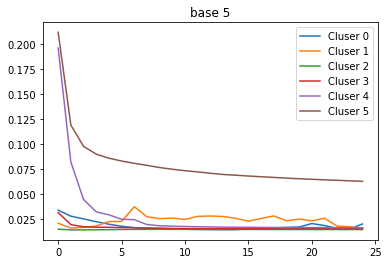

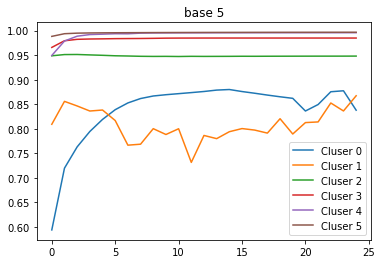

In [84]:
loud=True
test_loss_holder=[]
test_r2_holder=[]
for count,i in enumerate(M_Cluster):
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []
    model=torch.load("Temp.ckpt")
    descriptor_columns = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]


    model.fc1.weight.requires_grad = False
    model.fc1.bias.requires_grad = False
    model.fc2.weight.requires_grad = False
    model.fc2.bias.requires_grad = False


    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
    )

    data = i
    data = data.reset_index(drop=True)
    df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
        1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
    )

    df = df[0]
    df=df.drop("Cluster",axis=1)

    interest = one_filter_columns[0]
    #descriptor_columns.append("Cluster")
    features = descriptor_columns

    df_train, df_test, y_df_train, y_df_test = train_test_split(
        df[features], df[interest], test_size=0.2
    )
    y_df_train=y_df_train.reset_index(drop=False)
    df_train, df_val, y_df_train, y_df_val = train_test_split(
        df_train[features], y_df_train[interest], test_size=0.2
    )
    df_train[interest] = np.array(y_df_train)
    df_val[interest] = np.array(y_df_val)
    df_test[interest]=np.array(y_df_test)


    interest=one_filter_columns[0]

    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

    def train_step_1(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()


    transfer_trainer = Engine(train_step_1)
    metrics = {"loss": Loss(criterion), "r_2": R2Score()}
    @transfer_trainer.on(Events.EPOCH_COMPLETED(every=100))
    def store_metrics(engine):
        end = time.time()
        e = engine.state.epoch
        out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
        out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
        out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
        out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
        out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
        out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        print(e)
    transfer_trainer.logger.disabled=True
    transfer_trainer.run(train_loader, max_epochs=epochs)
    test_loss_holder.append(test_loss)
    test_r2_holder.append(test_r_2)
if loud:
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_loss_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()
    plt.show()
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_r2_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()
